# 제품 이상여부 판별 프로젝트

## 1. 데이터 불러오기

### 필수 라이브러리

In [30]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 엑셀 파일을 읽는 함수

읽어오는 속도가 느린 엑셀 파일을 위해 csv 파일로 변환하여 저장해 두고 사용합니다.

In [31]:
def read_excel_file(file_path: str, header: int = None) -> pd.DataFrame:
    csv_file = file_path.replace(".xlsx", ".csv")

    if not os.path.exists(csv_file):
        print("Converting excel to csv...")
        if header:
            df = pd.read_excel(file_path, header=header)
        else:
            df = pd.read_excel(file_path)

        df.to_csv(csv_file, index=False)
        print(f"  {file_path} -> {csv_file}")
        return df
    else:
        print(f"  Reading {csv_file}")
        return pd.read_csv(csv_file, low_memory=False)

### 엑셀 파일들 읽어오기

In [32]:
ROOT_DIR = "data"
RANDOM_STATE = 110

X_Dam = read_excel_file(os.path.join(ROOT_DIR, "Dam dispensing.xlsx"), header=1)

X_AutoClave = read_excel_file(
    os.path.join(ROOT_DIR, "Auto clave.xlsx"), header=1
)

X_Fill1 = read_excel_file(
    os.path.join(ROOT_DIR, "Fill1 dispensing.xlsx"), header=1
)

X_Fill2 = read_excel_file(
    os.path.join(ROOT_DIR, "Fill2 dispensing.xlsx"), header=1
)

y = pd.read_csv(os.path.join(ROOT_DIR, "train_y.csv"))

  Reading data\Dam dispensing.csv
  Reading data\Auto clave.csv
  Reading data\Fill1 dispensing.csv
  Reading data\Fill2 dispensing.csv


### 데이터 병합

x 데이터 병합

In [33]:
# Rename columns
X_Dam.columns = [i + " - Dam" for i in X_Dam.columns]
X_AutoClave.columns = [i + " - AutoClave" for i in X_AutoClave.columns]
X_Fill1.columns = [i + " - Fill1" for i in X_Fill1.columns]
X_Fill2.columns = [i + " - Fill2" for i in X_Fill2.columns]
X_Dam = X_Dam.rename(columns={"Set ID - Dam": "Set ID"})
X_AutoClave = X_AutoClave.rename(columns={"Set ID - AutoClave": "Set ID"})
X_Fill1 = X_Fill1.rename(columns={"Set ID - Fill1": "Set ID"})
X_Fill2 = X_Fill2.rename(columns={"Set ID - Fill2": "Set ID"})

# Merge X
X = pd.merge(X_Dam, X_AutoClave, on="Set ID")
X = pd.merge(X, X_Fill1, on="Set ID")
X = pd.merge(X, X_Fill2, on="Set ID")
X = X.drop(X[X.duplicated(subset="Set ID")].index).reset_index(drop=True)
X

,Wip Line - Dam,Process Desc. - Dam,Equipment - Dam,Model.Suffix - Dam,Workorder - Dam,LOT ID - Dam,Set ID,Box ID - Dam,Collect Date - Dam,Insp. Seq No. - Dam,...,Collect Result.37 - Fill2,Unit Time.37 - Fill2,Judge Value.37 - Fill2,Collect Result.38 - Fill2,Unit Time.38 - Fill2,Judge Value.38 - Fill2,Collect Result.39 - Fill2,Unit Time.39 - Fill2,Judge Value.39 - Fill2,Unnamed: 131 - Fill2
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000002,OP753345013050000002,NaN,2023-05-04 08:57:23,1,...,1,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000003,OP753345013050000003,NaN,2023-05-04 09:11:35,1,...,2,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
2,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000004,OP753345013050000004,NaN,2023-05-04 09:13:19,1,...,3,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
3,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000005,OP753345013050000005,NaN,2023-05-04 09:15:24,1,...,4,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000006,OP753345013050000006,NaN,2023-05-04 09:17:27,1,...,5,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57862,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334505,4F1XB738-1,OP753345054040002685,OP753345054040002685,NaN,2024-04-28 18:30:42,1,...,11,NaN,NaN,435,NaN,NaN,1,NaN,NaN,0.0
57863,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002686,OP753345054040002686,NaN,2024-04-28 18:31:43,1,...,5,NaN,NaN,436,NaN,NaN,1,NaN,NaN,0.0
57864,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334505,4F1XB738-1,OP753345054040002687,OP753345054040002687,NaN,2024-04-28 18:32:49,1,...,12,NaN,NaN,437,NaN,NaN,1,NaN,NaN,0.0
57865,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002688,OP753345054040002688,NaN,2024-04-28 18:33:51,1,...,6,NaN,NaN,438,NaN,NaN,1,NaN,NaN,0.0


In [34]:
# filtered_columns = [col for col in X.columns if 'Collect Date' in col]
# df_filtered = X[['Set ID'] + filtered_columns]
# df_filtered

x 데이터와 y 데이터 병합

In [35]:
# Merge X and y
df_merged = pd.merge(X, y, "inner", on="Set ID")

# Drop columns with more than half of the values missing
drop_cols = []
for column in df_merged.columns:
    if (df_merged[column].notnull().sum() // 2) < df_merged[
        column
    ].isnull().sum():
        drop_cols.append(column)
df_merged = df_merged.drop(drop_cols, axis=1)

# Drop Lot ID
df_merged = df_merged.drop("LOT ID - Dam", axis=1)
df_merged

,Wip Line - Dam,Process Desc. - Dam,Equipment - Dam,Model.Suffix - Dam,Workorder - Dam,Set ID,Collect Date - Dam,Insp. Seq No. - Dam,Insp Judge Code - Dam,Collect Result - Dam,...,Collect Result.31 - Fill2,Collect Result.32 - Fill2,Collect Result.33 - Fill2,Collect Result.34 - Fill2,Collect Result.35 - Fill2,Collect Result.36 - Fill2,Collect Result.37 - Fill2,Collect Result.38 - Fill2,Collect Result.39 - Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000003,2023-05-04 09:11:35,1,OK,240.0,...,91.8,270.0,50,85,18.200,5.0,2,1,0,AbNormal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000004,2023-05-04 09:13:19,1,OK,240.0,...,91.8,270.0,50,85,18.400,6.0,3,1,0,AbNormal
2,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000007,2023-05-04 09:19:31,1,OK,240.0,...,91.8,270.0,50,85,18.600,1.0,6,1,0,AbNormal
3,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000011,2023-05-04 11:19:55,1,OK,240.0,...,91.8,270.0,50,85,18.200,4.0,18,1,0,AbNormal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000024,2023-05-05 09:35:48,1,OK,240.0,...,91.8,270.0,50,85,18.100,6.0,12,1,0,AbNormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002680,2024-04-28 18:25:20,1,OK,240.0,...,50.0,91.8,270,50,114.612,18.8,2,430,1,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334505,4F1XB738-1,OP753345054040002681,2024-04-28 18:26:27,1,OK,1000.0,...,50.0,91.8,270,50,114.612,19.0,9,431,1,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002682,2024-04-28 18:27:27,1,OK,240.0,...,50.0,91.8,270,50,114.612,19.3,3,432,1,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002684,2024-04-28 18:29:36,1,OK,240.0,...,50.0,91.8,270,50,114.612,19.6,4,434,1,Normal


In [50]:
filtered_columns = [col for col in df_merged.columns if 'Collect Date' in col]
df_filtered = df_merged[['Set ID'] + ['target'] + filtered_columns]
df_filtered

,Set ID,target,Collect Date - Dam,Collect Date - AutoClave,Collect Date - Fill1,Collect Date - Fill2
0,OP753345013050000003,AbNormal,2023-05-04 09:11:35,2023-05-04 09:49:12,2023-05-04 09:13:39,2023-05-04 09:15:00
1,OP753345013050000004,AbNormal,2023-05-04 09:13:19,2023-05-04 09:49:12,2023-05-04 09:15:42,2023-05-04 09:17:04
2,OP753345013050000007,AbNormal,2023-05-04 09:19:31,2023-05-04 10:03:02,2023-05-04 09:21:54,2023-05-04 09:24:39
3,OP753345013050000011,AbNormal,2023-05-04 11:19:55,2023-05-04 11:50:09,2023-05-04 11:22:00,2023-05-04 11:23:21
4,OP753345013050000024,AbNormal,2023-05-05 09:35:48,2023-05-05 10:10:23,2023-05-05 09:36:57,2023-05-05 09:38:18
...,...,...,...,...,...,...
40501,OP753345054040002680,Normal,2024-04-28 18:25:20,2024-04-28 19:02:18,2024-04-28 18:27:10,2024-04-28 18:28:19
40502,OP753345054040002681,Normal,2024-04-28 18:26:27,2024-04-28 19:02:18,2024-04-28 18:28:13,2024-04-28 18:29:26
40503,OP753345054040002682,Normal,2024-04-28 18:27:27,2024-04-28 19:02:18,2024-04-28 18:29:17,2024-04-28 18:30:28
40504,OP753345054040002684,Normal,2024-04-28 18:29:36,2024-04-28 19:02:18,2024-04-28 18:31:24,2024-04-28 18:32:35


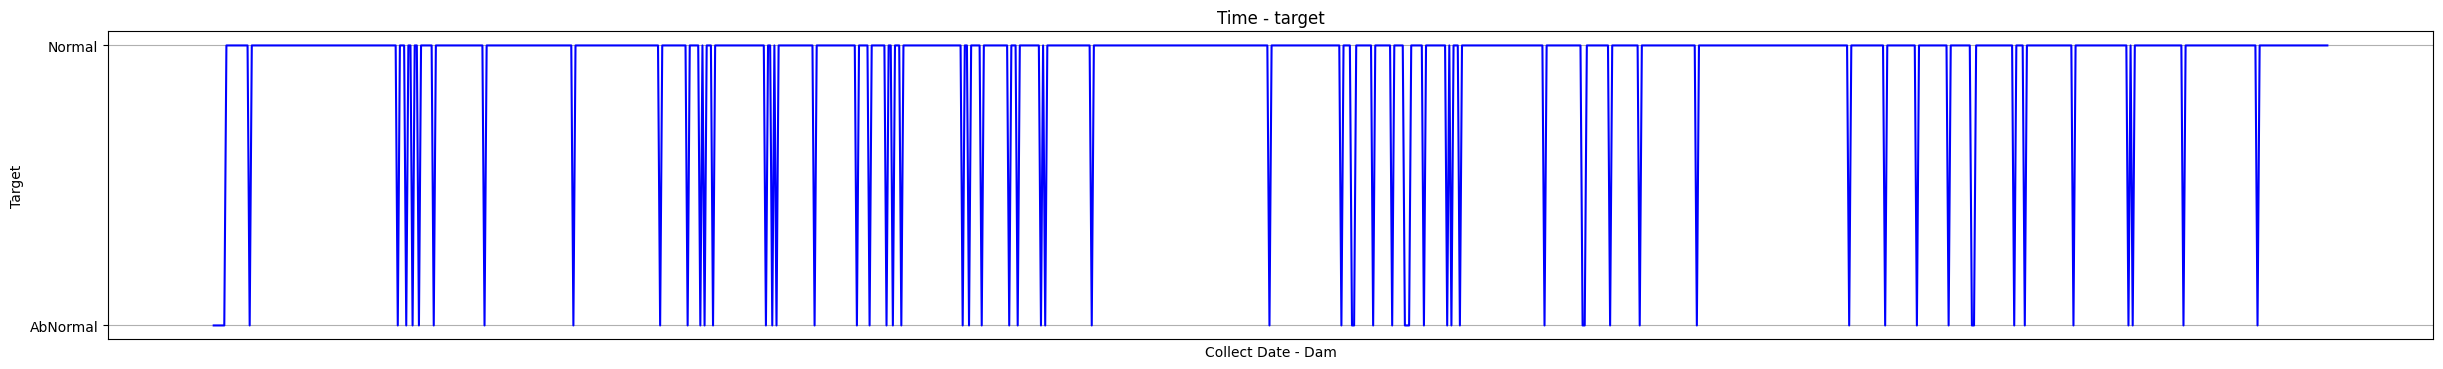

In [51]:
import matplotlib.pyplot as plt

df_filtered = df_filtered.head(1000)

plt.figure(figsize=(30, 4))
plt.plot(df_filtered['Collect Date - Dam'], df_filtered['target'], marker='', linestyle='-', color='b')
plt.xlabel('Collect Date - Dam')
plt.ylabel('Target')
plt.title('Time - target')
plt.grid(True)
plt.xticks([])

plt.show()

### 언더 샘플링

데이타 불균형을 해결하기 위해 언더 샘플링을 진행합니다.

In [7]:
normal_ratio = 1.0  # 1.0 means 1:1 ratio

df_normal = df_merged[df_merged["target"] == "Normal"]
df_abnormal = df_merged[df_merged["target"] == "AbNormal"]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(
    n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE
)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

  Total: Normal: 38156, AbNormal: 2350


target
AbNormal    2350
Normal      2350
Name: count, dtype: int64

### 데이터 분할

In [8]:
df_concat = df_concat.sort_values(by=["Collect Date - Dam"])
df_train, df_val = train_test_split(
    df_concat,
    test_size=0.3,
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(
        f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}"
        + f" ratio: {num_abnormal/num_normal}"
    )


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 1645, AbNormal: 1645 ratio: 1.0
  Total: Normal: 705, AbNormal: 705 ratio: 1.0


In [ ]:
filtered_columns = [col for col in df_merged.columns if 'Collect Date' in col]
df_filtered = df_merged[['Set ID'] + ['target'] + filtered_columns]
df_filtered

## 3. 모델 학습

### 모델 정의 

In [ ]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

### 모델 학습

In [ ]:
features = []

for col in df_train.columns:
    try:
        df_train[col] = df_train[col].astype(int)
        features.append(col)
    except:
        continue

if "Set ID" in features:
    features.remove("Set ID")

train_x = df_train[features]
train_y = df_train["target"]

model.fit(train_x, train_y)

## 4. 제출하기

### 테스트 데이터 예측

테스트 데이터 불러오기

In [ ]:
df_test_y = pd.read_csv(os.path.join("submission.csv"))

In [ ]:
df_test = pd.merge(X, df_test_y, "inner", on="Set ID")
df_test_x = df_test[features]

for col in df_test_x.columns:
    try:
        df_test_x.loc[:, col] = df_test_x[col].astype(int)
    except:
        continue

In [ ]:
test_pred = model.predict(df_test_x)
test_pred

### 제출 파일 작성

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**